In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import torch
import torchaudio 
from torchaudio import transforms
from torch.utils.data import random_split
from IPython.display import Audio

In [2]:
from classifier.audioutils import AudioUtils
from classifier.sounddataset import SoundDataset
from classifier.audioclassifier import AudioClassifier
import train

In [3]:
# Load audio input data into map

# NOTE: Assumes all samples are of the sample sample rate - if this is not the case add a method to AudioUtils to convert to 44100 (or whatever!)

CURRENT_DIR = os.getcwd()
AUDIO_DIR = os.path.join(CURRENT_DIR, "audio_input")

# Scan AUDIO_DIR and load all filenames into a map with key - path, value - label (1-10, 1. kick, 2. snare, ... 10.cymbal)

audio_datas = []
for subdir, dirs, files in os.walk(AUDIO_DIR):
    for file in files:
        if os.path.splitext(file)[-1] == ".wav":
            # get label for subdir
            label = int(os.path.split(subdir)[-1].split("_")[0])
            path = os.path.join(subdir, file)
            audio_datas.append((path, label))

print("Number of input files: ", len(audio_datas))

Number of input files:  2244


In [4]:
# Calculate the average length and use this to pad or truncate audio files to all be the same size
max_length = 0
lengths = []
for audio_data in audio_datas:
    sig, sr = AudioUtils.open(audio_data[0])
    max_length = max(max_length, sig.shape[1])
    lengths.append(sig.shape[1])

average_length = sum(lengths) / len(audio_datas)
desired_sample_len = int(average_length)

print("Max Length:", max_length, "Average Length:", average_length, "Sample Size:", desired_sample_len)


Max Length: 341501 Average Length: 20734.03787878788 Sample Size: 20734


In [5]:
# Create SoundDataset
audio_dataset = SoundDataset(audio_datas, 1, desired_sample_len)

# Random split 80:20 between training and validation
num_items = len(audio_dataset)
num_train = round(num_items * 0.8)
num_validate = num_items - num_train
train_ds, val_ds = random_split(audio_dataset, [num_train, num_validate])

# Create data loaders for training and validation
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
validation_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)


torch.Size([16, 1, 64, 162])
torch.Size([16])


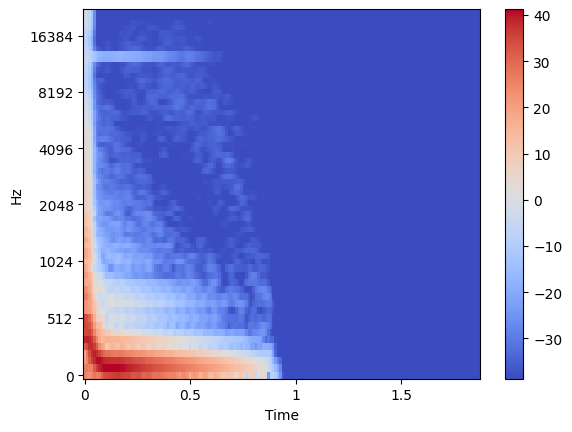

In [6]:
# Visualise the mel spectrogram of one entry

it = iter(train_dl)
first = next(it)

print(first[0].shape)
print(first[1].shape)

spec = transforms.AmplitudeToDB(top_db=80)(first[0][0][0])

plt.figure()
librosa.display.specshow(spec.cpu().numpy(), sr=sr, x_axis="time", y_axis="mel")
plt.colorbar()
plt.show()

In [7]:
# Create Model

model = AudioClassifier()
device = "cpu"
model.to(device)

AudioClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ap): AdaptiveAvgPool2d(output_size=1)
  (lin): Linear(in_features=64, out_features=10, bias=True)
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, mome

In [8]:
# Train
train.training(model, train_dl, 50)

[1,     1] loss: 0.238
[1,    11] loss: 2.515
[1,    21] loss: 4.694
[1,    31] loss: 6.757
[1,    41] loss: 8.688
[1,    51] loss: 10.491
[1,    61] loss: 12.208
[1,    71] loss: 13.913
[1,    81] loss: 15.458
[1,    91] loss: 17.089
[1,   101] loss: 18.675
[1,   111] loss: 20.241
Epoch: 0, Loss: 1.82, Accuracy: 0.43
Finished Training


torch.Size([10])
tensor([-0.8742,  0.3222,  0.1724,  0.4775,  0.3548,  0.1553, -0.8657, -0.1772,
         0.2546,  0.5034]) tensor(1)


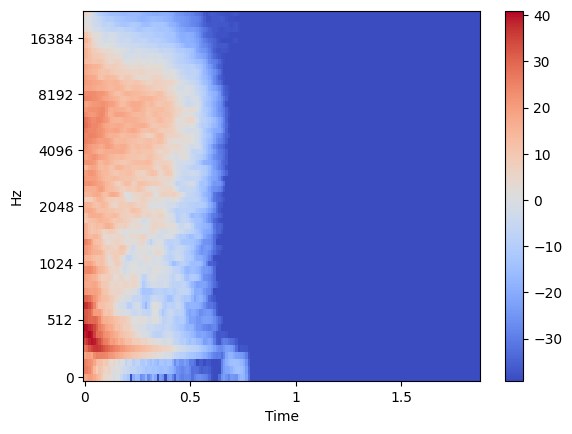

[('/Users/matthewharris/Development/neural/drum_classifier/audio_input/01_snare_drum/SD 909 Color 04.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio_input/00_bass_drum/BD S612 Room.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio_input/00_bass_drum/BD Drumulator MPC60 01.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio_input/06_tom/Tom 2600 01.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio_input/01_snare_drum/SD MO Mod 02.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio_input/06_tom/Tom LM1 Clean No Filt 01.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio_input/02_clap/Clap LM1 Color C 01.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio_input/05_rim/Rim 626 Color 03.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio_input/08_tambourine/Tambourine 707 SP1200.wav', '/Users/matthewharris/Development/neural/drum_classifier/audio_in

In [10]:
# Test the prediction on a sample from the validation data

with torch.no_grad():
    it = iter(validation_dl)
    first = next(it)

    inputs, labels, path = first[0].to(device), first[1].to(device), first[2]

    inputs_m, inputs_std = inputs.mean(), inputs.std()
    norm_input = (inputs - inputs_m) / inputs_std

    outputs = model(norm_input)

    print(outputs[0].shape)
    print(outputs[0], labels[0])

spec = transforms.AmplitudeToDB(top_db=80)(inputs[0][0])
plt.figure()
librosa.display.specshow(spec.cpu().numpy(), sr=sr, x_axis="time", y_axis="mel")
plt.colorbar()
plt.show()

print(path)